In [9]:
import sys
sys.path.append('../paleogeography')

import pygplates
import glob, re
import os
import numpy as np
from scipy import interpolate

import polygon_processing as pp
import paleogeography as pg
import paleogeography_tweening as pgt
import paleotopography as pt

from proximity_query import *
from create_gpml import create_gpml_regular_long_lat_mesh
import points_in_polygons
from sphere_tools import sampleOnSphere
import points_spatial_tree

import tempfile

reconstruction_basedir = '../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
tween_basedir = './tween_feature_collections/'
file_format = 'gpmlz'

output_dir = './Paleotopography_Grids/'

rotation_model = pygplates.RotationModel([f'{reconstruction_basedir}/Global_EB_250-0Ma_GK07_Matthews++.rot',
                                          f'{reconstruction_basedir}/Global_EB_410-250Ma_GK07_Matthews++.rot'])

COBterrane_file = f'{reconstruction_basedir}/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'

time_stage_min = 6.
time_stage_max = 14.

land_points_file = f'{tween_basedir}/tweentest_land_{time_stage_min:0.2f}Ma_{time_stage_max:0.2f}Ma.{file_format}'
marine_points_file = f'{tween_basedir}/tweentest_ocean_{time_stage_min:0.2f}Ma_{time_stage_max:0.2f}Ma.{file_format}'
mountains_going_up_file = f'{tween_basedir}/mountain_transgression_{time_stage_min:0.2f}Ma_{time_stage_max:0.2f}Ma.{file_format}'
mountains_going_down_file = f'{tween_basedir}/mountain_regression_{time_stage_min:0.2f}Ma_{time_stage_max:0.2f}Ma.{file_format}'
mountains_stable_file = f'{tween_basedir}/mountain_stable_{time_stage_min:0.2f}Ma_{time_stage_max:0.2f}Ma.{file_format}' 

reconstruction_time = 6.

#############################################
## Set the heights for different environment
#############################################
depth_for_unknown_ocean = -1000
# ----------------------------------
shallow_marine_elevation = -200.
# ----------------------------------
lowland_elevation = 200.
# ----------------------------------
max_mountain_elevation = 1500.
# NOTE - this height is actually the mountain height IN ADDITION TO the lowland height
# so that the maximum absolute elevation would be [lowland_elevation + max_mountain_elevation]
# TODO should call this 'mountain_relief'???
#############################################

# the grid sampling for the output
sampling = 1.0

# used for quadtree
subdivision_depth = 2

# get a nx3 array defining the points above sea-level, reconstructed to time of interest
# columns are [lat, long, elevation assigned for lowland]
land_point_array = pt.add_reconstructed_points_to_xyz(land_points_file,
                                                   rotation_model,
                                                   reconstruction_time,
                                                   lowland_elevation)

# get a nx3 array defining shallow marine areas, reconstructed to time of interest
# columns are [lat, long, elevation assigned for shallow marine]
marine_point_array = pt.add_reconstructed_points_to_xyz(marine_points_file,
                                                     rotation_model,
                                                     reconstruction_time,
                                                     shallow_marine_elevation)

# Note that the two arrays just created are based on 'regular' lat/long grids, but 
# are not aligned with the regular lat/long grid that we want to output
# since they are (usually) reconstructed to a different time from the one at which they
# were created (and anyway may be at a different resolution to the grid sampling specified
# here)

# combine the previous two arrays
pg_point_array = np.vstack((land_point_array, marine_point_array))

# get a merged version of COB terranes, optionally excluding polygons that are small in area
# TODO deal with donut polygons better
sieve_polygons = pt.get_merged_cob_terrane_polygons(
    COBterrane_file, rotation_model,reconstruction_time, sampling)

# get arrays defining the land and sea based on which points fall within the COB terranes
# NOTE this step is where we create the points that ARE on the regular lat/long grid we 
# will ultimately output
(lat,lon,zval,lat_deep,lon_deep,zval_deep) = pt.get_land_sea_multipoints(
    sieve_polygons, sampling, depth_for_unknown_ocean, subdivision_depth=subdivision_depth)

# sample the land/marine points onto the points within the COB Terranes
# This will fill the gaps that exist within continents, and average out overlaps
d,l = sampleOnSphere(pg_point_array[:,0],pg_point_array[:,1],pg_point_array[:,2],
                     np.array(lat),np.array(lon),n=1)

land_marine_interp_points = pg_point_array[:,2].ravel()[l]


In [2]:
area_threshold = 0.0001
mountain_buffer_distance_degrees = 0.001

dat4 = pt.add_reconstructed_points_to_xyz(mountains_going_down_file, rotation_model, reconstruction_time+0.01,1)
dat5 = pt.add_reconstructed_points_to_xyz(mountains_stable_file, rotation_model, reconstruction_time+0.01,1)
mountains_tr_point_array = np.vstack((dat4, dat5))

dist_tr = pt.get_distance_to_mountain_edge(mountains_tr_point_array, reconstruction_basedir,
                                        rotation_model, reconstruction_time, area_threshold)
dist_tr_cap = np.array(dist_tr)
dist_tr_cap[np.array(dist_tr)>mountain_buffer_distance_degrees] = mountain_buffer_distance_degrees

dist_tr_cap = dist_tr_cap*mountains_tr_point_array[:,2]

normalized_mountain_elevation = dist_tr_cap

d,l = sampleOnSphere(mountains_tr_point_array[:,0], mountains_tr_point_array[:,1], normalized_mountain_elevation,
                     np.array(lat), np.array(lon), k=4)
w = 1./d**2
normalized_mountain_elevation_interp_points = np.sum(w * normalized_mountain_elevation.ravel()[l],axis=1) / np.sum(w,axis=1)

mountain_proximity_index = np.degrees(np.min(d, axis=1))< sampling*2 #mountain_buffer_distance_degrees

# convert the normalized mountain elevations to metres, then write to file
mountain_elevation_factor = max_mountain_elevation / mountain_buffer_distance_degrees
mountain_elevation_array = normalized_mountain_elevation_interp_points[mountain_proximity_index]*mountain_elevation_factor


['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


0.0003653864129392253
[ 200.  200.  200. ... -200. -200. -200.]


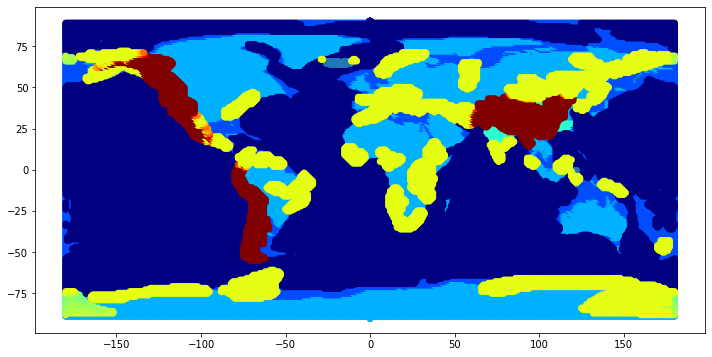

In [3]:
import matplotlib
import matplotlib.pyplot as plt

print(min(np.degrees(np.min(d, axis=1))))

fig, ax = plt.subplots(figsize=(12, 6))
print(land_marine_interp_points)
plt.scatter(lon+lon_deep,lat+lat_deep, c=land_marine_interp_points.tolist()+zval_deep, vmin=-1000, vmax=3000, cmap='jet')

plt.scatter(mountains_tr_point_array[:,1], mountains_tr_point_array[:,0])

plt.scatter(np.array(lon)[mountain_proximity_index],
            np.array(lat)[mountain_proximity_index], c=mountain_elevation_array, vmin=-1000, vmax=3000, cmap='jet')


0.003 0.0006354760616628991


(array([  24., 2404.,    0.,    0.,    0.,  703.,    0.,    0.,    0.,
         585.]),
 array([0.00063548, 0.00087193, 0.00110838, 0.00134483, 0.00158129,
        0.00181774, 0.00205419, 0.00229064, 0.0025271 , 0.00276355,
        0.003     ]),
 <BarContainer object of 10 artists>)

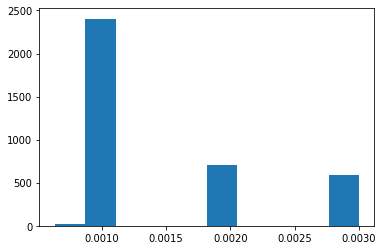

In [10]:
data=dist_tr_cap
print(max(data), min(data))
plt.hist(data)


-1000 -1000


(array([    0.,     0.,     0.,     0.,     0., 33834.,     0.,     0.,
            0.,     0.]),
 array([-1000.5, -1000.4, -1000.3, -1000.2, -1000.1, -1000. ,  -999.9,
         -999.8,  -999.7,  -999.6,  -999.5]),
 <BarContainer object of 10 artists>)

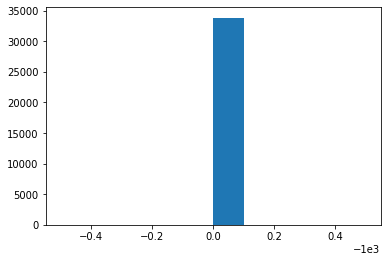

In [5]:
print(max(zval_deep), min(zval_deep))
plt.hist(zval_deep)

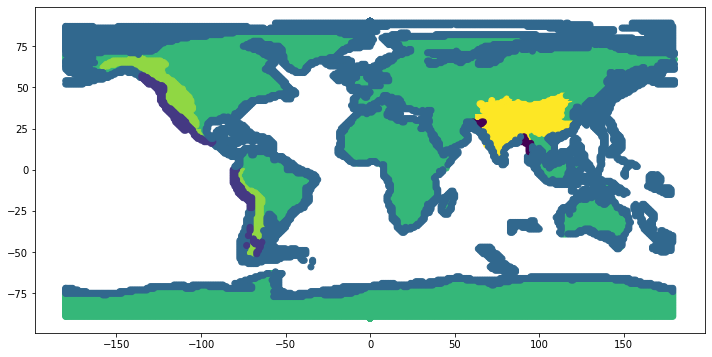

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.scatter(pg_point_array[:,1],pg_point_array[:,0],c=pg_point_array[:,2])

In [7]:
from importlib import reload  
import sphere_tools
reload(sphere_tools)
d,l = sphere_tools.sampleOnSphere(mountains_tr_point_array[:,1], mountains_tr_point_array[:,0], normalized_mountain_elevation,
                     np.array([-90]), np.array([20]), k=1)
print(d)
print(l)
print(mountains_tr_point_array[:,1][l[0]])
print(mountains_tr_point_array[:,0][l[0]])
print(np.degrees(d[0]))


[3.14763854e-05]
[758]
-89.99819653596201
18.00137484588498
0.0018034640379219842


In [8]:
print(sphere_tools.rtp2xyz(np.array([1]),np.array([0]),np.array([30])))

[[ 0. -0.  1.]]
